In [1]:
import sympy as sym

import numpy as np

import itertools

sym.init_printing()

In [2]:
from importlib.machinery import SourceFileLoader


evolution = SourceFileLoader("evolution", "src/evolution.py").load_module()
formulation = SourceFileLoader("formulation", "src/formulation.py").load_module()

simulation = SourceFileLoader("simulation", "src/simulation.py").load_module()

In [3]:
import matplotlib.pyplot as plt
import matplotlib

from collections import Counter

In [4]:
from tqdm import tqdm

In [5]:
import pandas as pd

**Defining variables**

In [56]:
y_1, p_1, q_1 = sym.symbols("y_1, p_1, q_1")
y_2, p_2, q_2 = sym.symbols("y_2, p_2, q_2")

In [57]:
s_one = (y_1, p_1, q_1)
s_two = (y_2, p_2, q_2)

In [58]:
s_one

**Get expression using code**

In [59]:
d = sym.symbols("delta")

In [60]:
v_zero = formulation.expected_distribution_opening_round(s_one, s_two)

In [61]:
v_zero

In [62]:
M = formulation.markov_chain_for_reactive_strategies(s_one, s_two)

In [63]:
inverse = sym.Matrix(np.identity(4) - d * M).inverse_ADJ()

In [64]:
inverse = inverse.applyfunc(sym.simplify)

In [65]:
expression = (1 - d) * sym.Matrix(v_zero).reshape(1, 4) @ inverse

**Check the written mathematics**

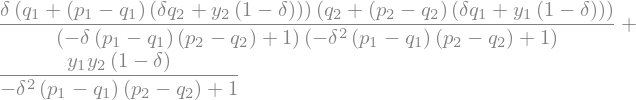

In [66]:
u_R = formulation.probability_being_in_state_R(s_one, s_two, d)
u_R

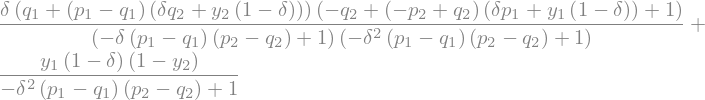

In [67]:
u_S = formulation.probability_being_in_state_S(s_one, s_two, d)
u_S

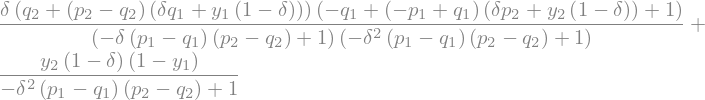

In [68]:
u_T = formulation.probability_being_in_state_T(s_one, s_two, d)
u_T

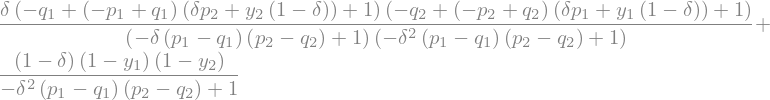

In [69]:
u_P = formulation.probability_being_in_state_P(s_one, s_two, d)
u_P

In [70]:
(u_R - expression[0]).simplify(), (u_S - expression[1]).factor()

In [71]:
(u_T - expression[2]).factor(), (u_P - expression[3]).factor()

**Check functions for analysis of ALLD into GTFT**

In [72]:
q = sym.symbols("q")

N, k = sym.symbols("N, k")

In [73]:
ALLD = (0, 0, 0)
GTFT = (1, 1, q)

**States of Eq. (9) and (10)**

In [75]:
formulation.probability_being_in_state_R(GTFT, GTFT, d).factor()

In [76]:
formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [77]:
formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [78]:
formulation.probability_being_in_state_T(ALLD, GTFT, d).factor()

In [79]:
(
    formulation.probability_being_in_state_S(GTFT, GTFT, d).factor(),
    formulation.probability_being_in_state_T(GTFT, GTFT, d).factor(),
    formulation.probability_being_in_state_P(GTFT, GTFT, d).factor(),
)

In [80]:
formulation.probability_being_in_state_R(ALLD, GTFT, d).factor(), main.probability_being_in_state_S(
    ALLD, GTFT, d
).factor()

In [81]:
formulation.probability_being_in_state_T(ALLD, GTFT, d).factor(), main.probability_being_in_state_P(
    ALLD, GTFT, d
).factor()

**Ep. (11)**

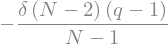

In [83]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_R,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).factor()

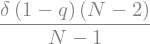

In [84]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_R,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).factor().collect(1 - q)

In [85]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_S,
    opponent_state=main.probability_being_in_state_T,
    N=N,
    k=1,
    delta=d,
).factor()

In [86]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_P,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).expand()

In [87]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_P,
    opponent_state=main.probability_being_in_state_S,
    N=N,
    k=1,
    delta=d,
).simplify()

In [88]:
formulation.probability_being_in_state_S(GTFT, ALLD, d).factor()

In [89]:
formulation.probability_being_in_state_R(ALLD, GTFT, d).factor()

In [90]:
formulation.probability_being_in_state_R(ALLD, ALLD, d).factor()

In [92]:
formulation.probability_of_receiving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_S,
    opponent_state=main.probability_being_in_state_R,
    N=N,
    k=1,
    delta=d,
).simplify()

**Fixation probabilities**

In [93]:
R, S, T, P = sym.symbols('R, S, T, P')

In [94]:
b = sym.symbols('beta')
b

In [95]:
expr = (evolution.probability_mutant_increases(GTFT, ALLD, N, k=1, delta=d, beta=b, payoffs=[R, S, T, P]) /
        evolution.probability_mutant_descreases(GTFT, ALLD, N, k=1, delta=d, beta=b, payoffs=[R, S, T, P]))


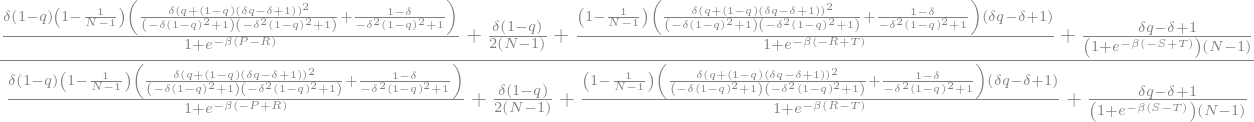

In [96]:
expr

In [97]:
numerator_first_term = ((1 - d + d * q) / (1 + sym.exp(-b * (T - R))) + ((d * (1 - q)) / (1 + sym.exp(-b * (P - R)))))

In [98]:
numerator_second_term = ((1 - d + d * q) / (1 + sym.exp(-b * (T - S))) + ((d * (1 - q)) / 2))

In [99]:
denominator_first_term = ((1 - d + d * q) / (1 + sym.exp(-b * (R - T))) + ((d * (1 - q)) / (1 + sym.exp(-b * (R - P)))))

In [100]:
denominator_second_term = ((1 - d + d * q) / (1 + sym.exp(-b * (S - T))) + ((d * (1 - q)) / 2))

In [101]:
written_expr = (((N - 2) / (N - 1)) * numerator_first_term + (1 / (N - 1)) * numerator_second_term) / (((N - 2) / (N - 1)) * denominator_first_term + (1 / (N - 1)) * denominator_second_term)

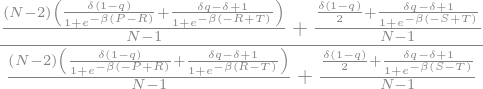

In [102]:
written_expr

In [103]:
(expr - written_expr).factor()

**Simulations** - **Example in notes**

In [11]:
N_val = 100
d_val = 1 - (10 ** -3)
b_val = 1

In [24]:
number_of_steps = 10 ** 2

In [25]:
payoffs = donation_game(1, 3)

In [35]:
history = simulation.main(N_val, d_val, b_val, number_of_steps, payoffs, 'e')

100%|██████████| 100/100 [00:00<00:00, 230.08it/s]


**Plotting simulation results**

In [91]:
df = pd.read_csv('expected_payoff_data.csv', header=None)

In [92]:
x, y, weights = simulation._reshape_history(df.values)

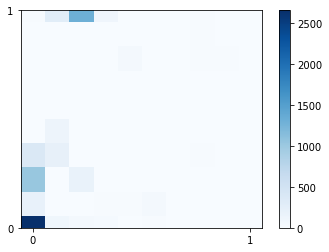

In [93]:
cmap = matplotlib.cm.get_cmap('Blues')

heatmap, xedges, yedges = np.histogram2d(x, y, bins=10, weights=weights)


fig, ax = plt.subplots()
cax = ax.imshow(heatmap, cmap=cmap);

max_score = max(weights)
min_score = min(weights)

ticks = [min_score, (max_score + min_score) / 2, max_score]

fig.colorbar(cax)

plt.ylim(0, len(yedges) - 2), plt.ylim(0, len(yedges) - 2)
plt.xticks([0, len(xedges) - 2], ["0", "1"])
plt.yticks([0, len(yedges) - 2], ["0", "1"]);

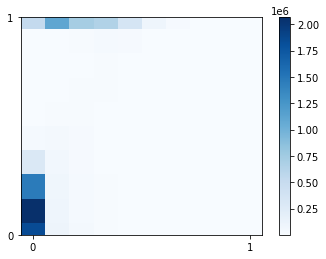

In [55]:
cmap = matplotlib.cm.get_cmap('Blues')

heatmap, xedges, yedges = np.histogram2d(x, y, weights=weights)


fig, ax = plt.subplots()
cax = ax.imshow(heatmap, cmap=cmap);

max_score = max(weights)
min_score = min(weights)

ticks = [min_score, (max_score + min_score) / 2, max_score]

fig.colorbar(cax)

plt.ylim(0, len(yedges) - 2), plt.ylim(0, len(yedges) - 2)
plt.xticks([0, len(xedges) - 2], ["0", "1"])
plt.yticks([0, len(yedges) - 2], ["0", "1"]);

In [ ]:
def ratio_of_mutant_fixation_for_simulations(resident, mutant, N, k, delta, beta, payoffs):

    return evolution.probability_mutant_descreases(
        resident, mutant, N, k, delta, beta, payoffs
    ) / evolution.probability_mutant_increases(
        resident, mutant, N, k, delta, beta, payoffs
    )


In [98]:
payoffs = donation_game(c, b)

In [123]:
labels = itertools.product(['R', 'S', 'T', 'P'], repeat=2)
payoffs_ = itertools.product(
    payoffs,
    repeat=2,
)

In [124]:
payoff_dict = {}

for label, payoff in zip(labels, payoffs_):
    if label in [('R', 'R'), ('S', 'T'), ('T', 'S'), ('P', 'P')]:
        payoff_dict[label] = payoff

In [125]:
payoff_dict

{('R', 'R'): (b - c, b - c),
 ('S', 'T'): (-c, b),
 ('T', 'S'): (b, -c),
 ('P', 'P'): (0, 0)}

In [ ]:
payoff_dict

In [114]:
player = (0, 0, 0)
opponent = (1, 1, 1)
delta = sym.symbols('delta')

In [157]:
states = itertools.product(
    [
        formulation.probability_being_in_state_R(player, player, delta),
        formulation.probability_being_in_state_R(player, opponent, delta),
        formulation.probability_being_in_state_R(opponent, opponent, delta),
        formulation.probability_being_in_state_R(opponent, player, delta),

        formulation.probability_being_in_state_S(player, opponent, delta),
        formulation.probability_being_in_state_S(player, player, delta),
        formulation.probability_being_in_state_S(opponent, opponent, delta),
        formulation.probability_being_in_state_S(opponent, player, delta),
        
        formulation.probability_being_in_state_T(player, opponent, delta),
        formulation.probability_being_in_state_T(player, player, delta),
        formulation.probability_being_in_state_T(opponent, opponent, delta),
        formulation.probability_being_in_state_T(opponent, player, delta),
        
        formulation.probability_being_in_state_P(player, opponent, delta),
        formulation.probability_being_in_state_P(player, player, delta),
        formulation.probability_being_in_state_P(opponent, opponent, delta),
        formulation.probability_being_in_state_P(opponent, player, delta),
    ],
    repeat=1,
)

In [160]:
labels = list(itertools.product(['R', 'S', 'T', 'P'], ['player', 'opponent'], repeat=2))

In [158]:
labels = list(itertools.product(['R', 'S', 'T', 'P'], ['player', 'opponent'], repeat=2))
states_dict = {}

for label, state in zip(labels, states):
    if (label[0], label[2]) in [('R', 'R'), ('S', 'T'), ('T', 'S'), ('P', 'P')]:
        states_dict[label] = state

In [153]:
states_dict

{('R', 'player', 'R', 'player'): (0, 0),
 ('R', 'player', 'R', 'opponent'): (0, 0),
 ('R', 'opponent', 'R', 'player'): (0, 1),
 ('R', 'opponent', 'R', 'opponent'): (0, 0),
 ('S', 'player', 'T', 'player'): (0, 0),
 ('S', 'player', 'T', 'opponent'): (0, 0),
 ('S', 'opponent', 'T', 'player'): (0, 0),
 ('S', 'opponent', 'T', 'opponent'): (0, 1),
 ('T', 'player', 'S', 'player'): (1, 1),
 ('T', 'player', 'S', 'opponent'): (1, 0),
 ('T', 'opponent', 'S', 'player'): (1, 0),
 ('T', 'opponent', 'S', 'opponent'): (1, 0),
 ('P', 'player', 'P', 'player'): (0, 0),
 ('P', 'player', 'P', 'opponent'): (0, 1),
 ('P', 'opponent', 'P', 'player'): (0, 0),
 ('P', 'opponent', 'P', 'opponent'): (0, 0)}

In [ ]:
def chi_for_simulations(N, k, player_state, opponent_state):
    
    first_term = (1 / (N - 1)) * states_dict[(player_state, 'player', opponent_state, 'opponent')]
    
    second_term_case_one = (
        ((k - 1) / (N - 2))
        * ((k - 2) / (N - 3))
        * states_dict[(player_state, 'player', opponent_state, 'opponent')] * states_dict[(player_state, 'player', opponent_state, 'opponent')]
        * opponent_state(opponent, opponent, delta)
    )
    second_term_case_two = (
        ((k - 1) / (N - 2))
        * ((N - k - 1) / (N - 3))
        * player_state(player, opponent, delta)
        * opponent_state(opponent, player, delta)
    )
    second_term_case_three = (
        ((N - k - 1) / (N - 2))
        * ((k - 1) / (N - 3))
        * player_state(player, player, delta)
        * opponent_state(opponent, opponent, delta)
    )
    second_term_case_four = (
        ((N - k - 1) / (N - 2))
        * ((N - k - 2) / (N - 3))
        * player_state(player, player, delta)
        * opponent_state(opponent, player, delta)
    )
    
    return first_term + (1 - 1 / (N - 1)) * (
        second_term_case_one
        + second_term_case_two
        + second_term_case_three
        + second_term_case_four
    )

In [144]:
N_val = 10

In [ ]:
for k in range(N_val):
    increase_probability = sum